In [81]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn import tree

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
from __future__ import print_function
import graphviz

# Load Dataset

In [2]:
e_open = pd.read_csv('../DS_Challenges/Marketing_Email_Campaign/email_opened_table.csv')
e_click = pd.read_csv('../DS_Challenges/Marketing_Email_Campaign/link_clicked_table.csv')
email = pd.read_csv('../DS_Challenges/Marketing_Email_Campaign/email_table.csv')

In [3]:
e_open.head()

,email_id
0,284534
1,609056
2,220820
3,905936
4,164034


In [4]:
e_click.head()

,email_id
0,609056
1,870980
2,935124
3,158501
4,177561


In [5]:
email.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases
0,85120,short_email,personalized,2,Sunday,US,5
1,966622,long_email,personalized,12,Sunday,UK,2
2,777221,long_email,personalized,11,Wednesday,US,2
3,493711,short_email,generic,6,Monday,UK,1
4,106887,long_email,generic,14,Monday,US,6


In [6]:
e_click.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2119 entries, 0 to 2118
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   email_id  2119 non-null   int64
dtypes: int64(1)
memory usage: 16.7 KB


In [9]:
# unique email_id in click
len(e_click['email_id'].unique())

2119

In [7]:
e_open.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10345 entries, 0 to 10344
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   email_id  10345 non-null  int64
dtypes: int64(1)
memory usage: 80.9 KB


In [10]:
# unique email_id in open
len(e_open['email_id'].unique())

10345

In [11]:
email.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   email_id             100000 non-null  int64 
 1   email_text           100000 non-null  object
 2   email_version        100000 non-null  object
 3   hour                 100000 non-null  int64 
 4   weekday              100000 non-null  object
 5   user_country         100000 non-null  object
 6   user_past_purchases  100000 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 5.3+ MB


In [12]:
# unique email_id in email
len(email.email_id.unique())

100000

# Data Processing and Cleaning

In [15]:
# add columns to e_open and e_click
e_open['open'] = 1
e_click['click'] = 1

In [20]:
# merge three datasets
data = email.merge(e_open, on = 'email_id', how = 'left').merge(e_click, on = 'email_id', how = 'left')
data.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,open,click
0,85120,short_email,personalized,2,Sunday,US,5,NaN,NaN
1,966622,long_email,personalized,12,Sunday,UK,2,1.0,1.0
2,777221,long_email,personalized,11,Wednesday,US,2,NaN,NaN
3,493711,short_email,generic,6,Monday,UK,1,NaN,NaN
4,106887,long_email,generic,14,Monday,US,6,NaN,NaN


In [24]:
data.isnull().sum()

email_id                   0
email_text                 0
email_version              0
hour                       0
weekday                    0
user_country               0
user_past_purchases        0
open                   89655
click                  97881
dtype: int64

In [26]:
data = data.fillna(0)

# Question 1

### What percentage of users opened the email ?

In [29]:
print(f"{data['open'].mean()*100} % of users opened the email.")

10.345 % of users opened the email.


### what percentage clicked on the link within the email?

In [30]:
print(f"{data['click'].mean()*100} % of users clicked on the link within the email.")

2.119 % of users clicked on the link within the email.


# Question 2

## Feature engineering

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   email_id             100000 non-null  int64  
 1   email_text           100000 non-null  object 
 2   email_version        100000 non-null  object 
 3   hour                 100000 non-null  int64  
 4   weekday              100000 non-null  object 
 5   user_country         100000 non-null  object 
 6   user_past_purchases  100000 non-null  int64  
 7   open                 100000 non-null  float64
 8   click                100000 non-null  float64
dtypes: float64(2), int64(3), object(4)
memory usage: 10.1+ MB


short_email, personalized email, high user-past-purchase, noon/23/24pm, user from UK and US, weekdays except for friday tend to have high click ratio.

### Visualization of `email_text`

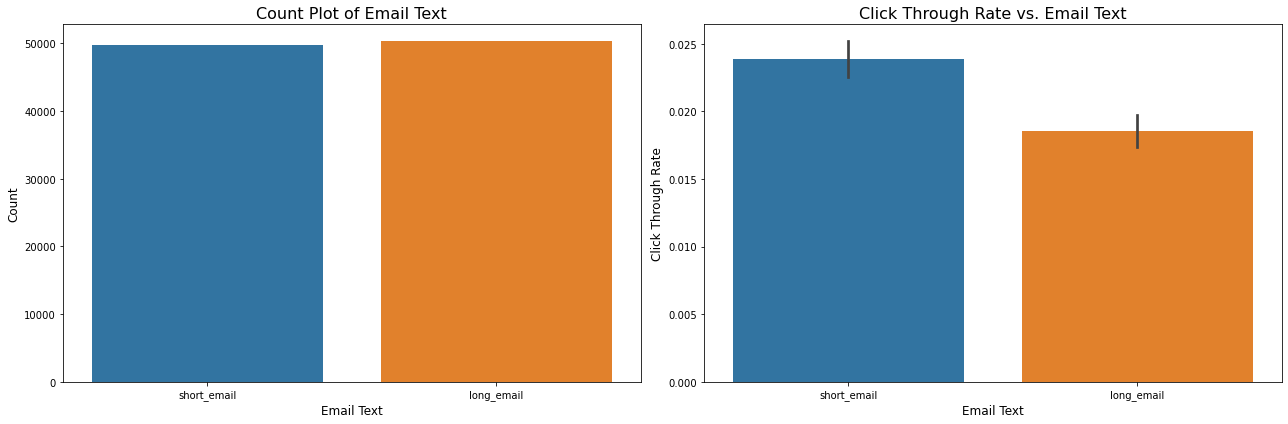

In [73]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='email_text', data=data, ax=ax[0])
ax[0].set_xlabel('Email Text', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Email Text', fontsize=16)

sns.barplot(x='email_text', y='click', data=data, ax=ax[1])
ax[1].set_xlabel('Email Text', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Email Text', fontsize=16)
plt.tight_layout()
plt.show()

### Visualization of `email_version`

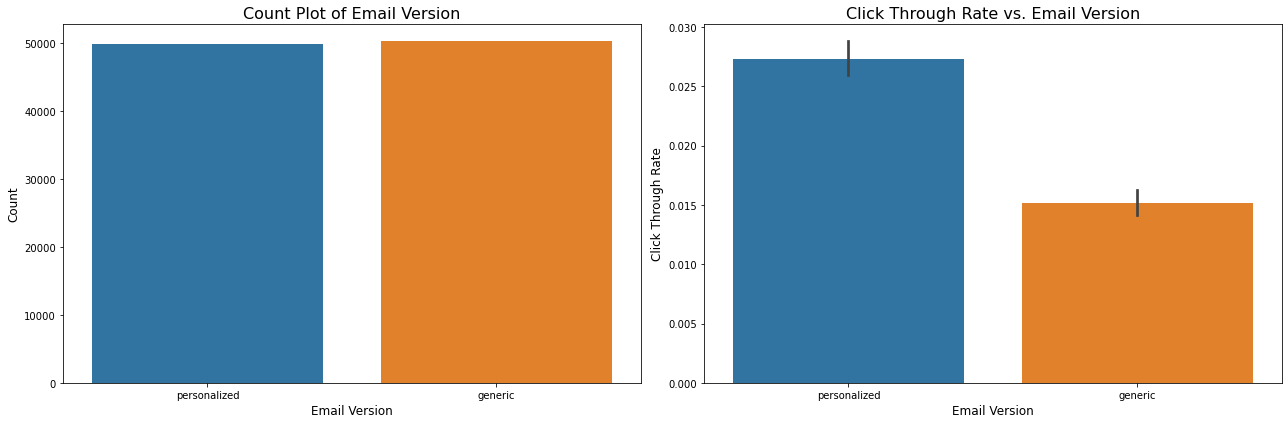

In [74]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='email_version', data=data, ax=ax[0])
ax[0].set_xlabel('Email Version', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Email Version', fontsize=16)

sns.barplot(x='email_version', y='click', data=data, ax=ax[1])
ax[1].set_xlabel('Email Version', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Email Version', fontsize=16)
plt.tight_layout()
plt.show()

### Visualization of `hour`

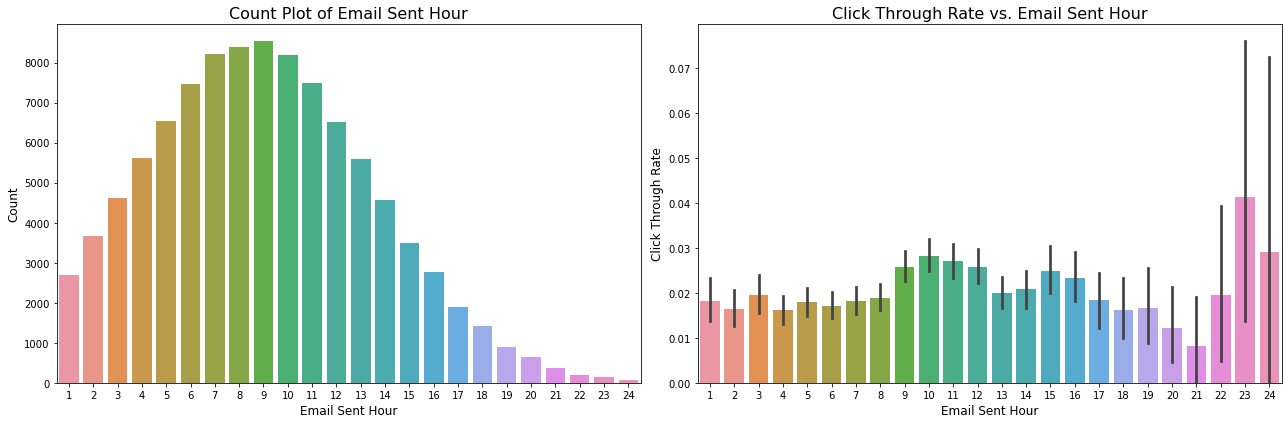

In [75]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='hour', data=data, ax=ax[0])
ax[0].set_xlabel('Email Sent Hour', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Email Sent Hour', fontsize=16)

sns.barplot(x='hour', y='click', data=data, ax=ax[1])
ax[1].set_xlabel('Email Sent Hour', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Email Sent Hour', fontsize=16)
plt.tight_layout()
plt.show()

### Visualization of `weekday`

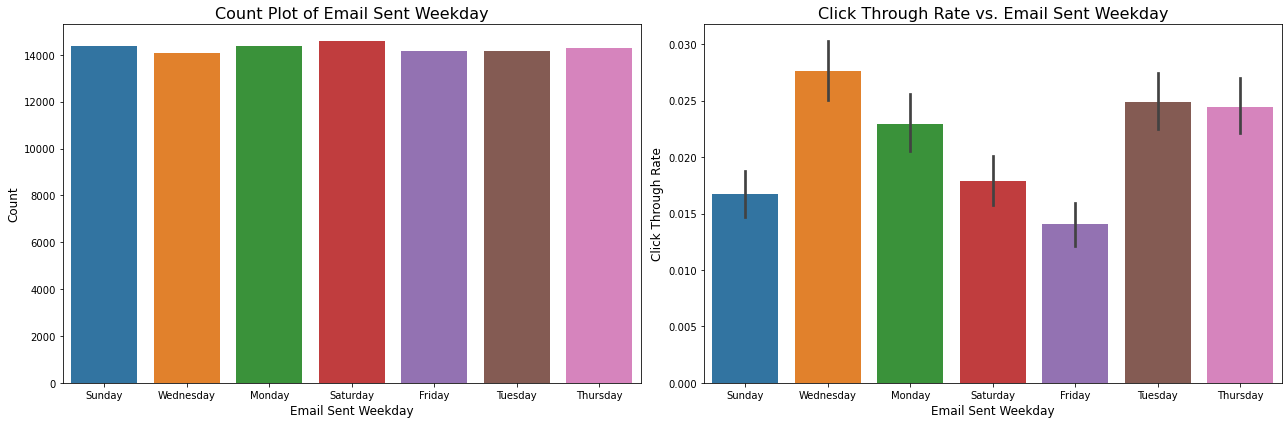

In [76]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='weekday', data=data, ax=ax[0])
ax[0].set_xlabel('Email Sent Weekday', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Email Sent Weekday', fontsize=16)

sns.barplot(x='weekday', y='click', data=data, ax=ax[1])
ax[1].set_xlabel('Email Sent Weekday', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Email Sent Weekday', fontsize=16)
plt.tight_layout()
plt.show()

### Visualization of `user_country`

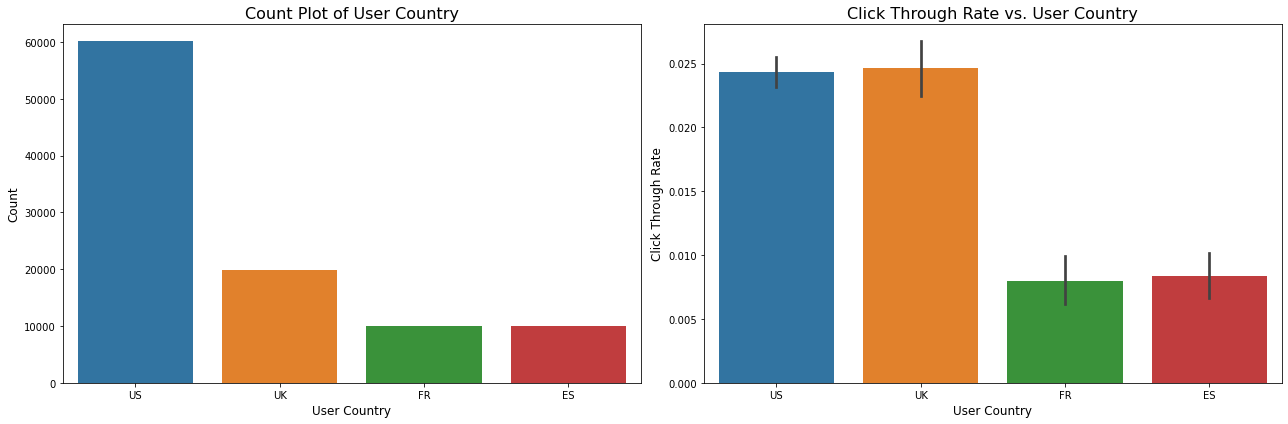

In [77]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='user_country', data=data, ax=ax[0])
ax[0].set_xlabel('User Country', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of User Country', fontsize=16)

sns.barplot(x='user_country', y='click', data=data, ax=ax[1])
ax[1].set_xlabel('User Country', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. User Country', fontsize=16)
plt.tight_layout()
plt.show()

### Visualization of `user_past_purchases`

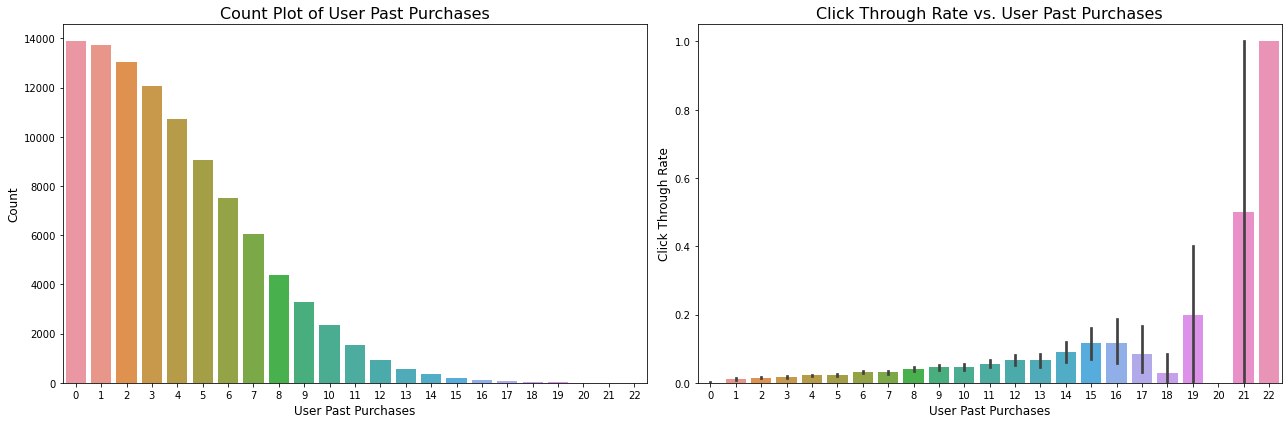

In [78]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='user_past_purchases', data=data, ax=ax[0])
ax[0].set_xlabel('User Past Purchases', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of User Past Purchases', fontsize=16)

sns.barplot(x='user_past_purchases', y='click', data=data, ax=ax[1])
ax[1].set_xlabel('User Past Purchases', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. User Past Purchases', fontsize=16)
plt.tight_layout()
plt.show()

## Modelling

### Decision Tree

In [42]:
# One-Hot-Encoding on categorical features
dummy = pd.get_dummies(data)

In [46]:
# a categorical feature of K unique values, only need K-1 vectors
# I don't use 'drop_first' parameter in get_dummies, since it cannot specify which level to drop
del dummy['email_text_long_email']
del dummy['email_version_generic']
del dummy['weekday_Monday']
del dummy['user_country_FR']

In [47]:
X = dummy.drop(columns = ['email_id','open','click'])
y = dummy.loc[:,'click']

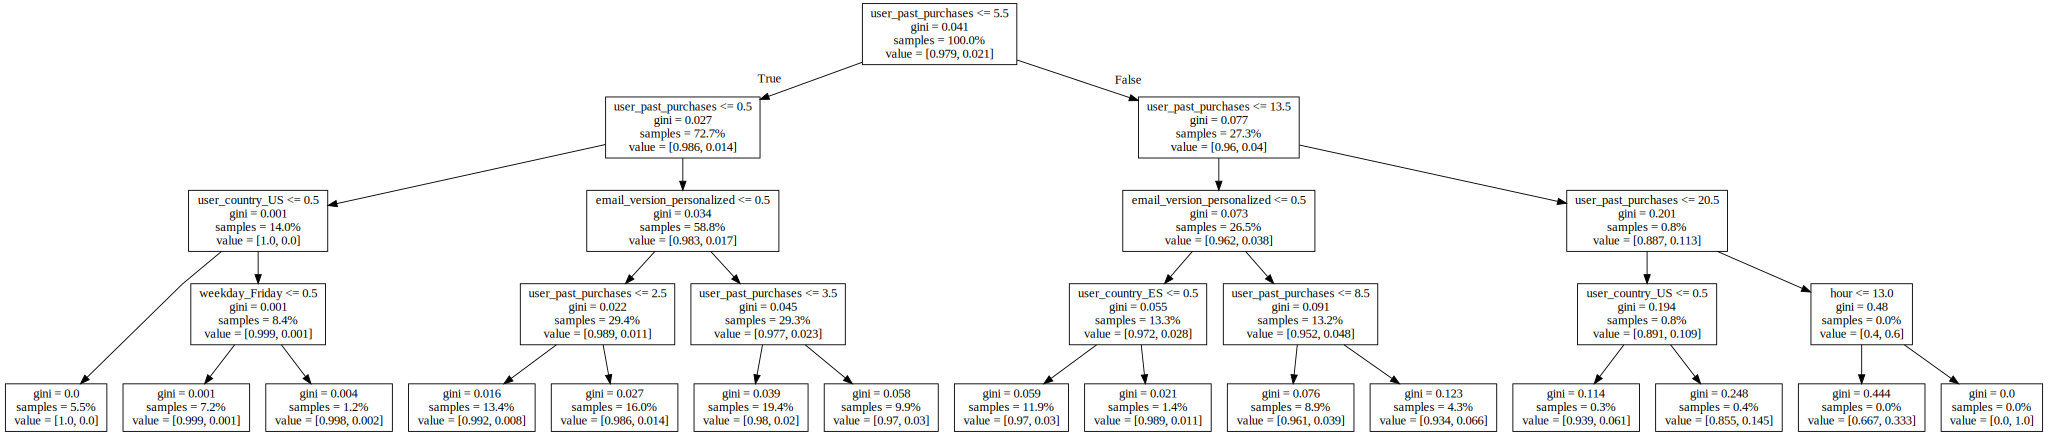

In [55]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1024)
tree_model = DecisionTreeClassifier(random_state=1024, max_depth=4, min_samples_split=5)
tree_model.fit(X_train,y_train)
feature_names = X.columns
tree_graph = tree.export_graphviz(tree_model, proportion=True, out_file=None, feature_names=feature_names,leaves_parallel=True)
graphviz.Source(tree_graph)

In [57]:
pd.Series(tree_model.feature_importances_,index = X_train.columns).sort_values(ascending=False)

user_past_purchases           0.780000
email_version_personalized    0.143868
user_country_US               0.041192
hour                          0.020455
user_country_ES               0.014408
weekday_Friday                0.000077
user_country_UK               0.000000
weekday_Wednesday             0.000000
weekday_Tuesday               0.000000
weekday_Thursday              0.000000
weekday_Sunday                0.000000
weekday_Saturday              0.000000
email_text_short_email        0.000000
dtype: float64

### h20

In [83]:
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.6" 2020-01-14; OpenJDK Runtime Environment (build 11.0.6+8-b765.1); OpenJDK 64-Bit Server VM (build 11.0.6+8-b765.1, mixed mode)
  Starting server from /Users/yli/opt/anaconda3/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/df/669jwmvs7m78zz36wmxbr_zm0000gn/T/tmp0xay9g4z
  JVM stdout: /var/folders/df/669jwmvs7m78zz36wmxbr_zm0000gn/T/tmp0xay9g4z/h2o_yli_started_from_python.out
  JVM stderr: /var/folders/df/669jwmvs7m78zz36wmxbr_zm0000gn/T/tmp0xay9g4z/h2o_yli_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Asia/Shanghai
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.2
H2O_cluster_version_age:,1 month
H2O_cluster_name:,H2O_from_python_yli_uenf74
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


In [85]:
# Transform to H2O Frame, and make sure the target variable is categorical
h2o_df = H2OFrame(data)
h2o_df['click'] = h2o_df['click'].asfactor()
h2o_df['open'] = h2o_df['open'].asfactor()

h2o_df.summary()

Parse progress: |█████████████████████████████████████████████████████████| 100%


,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,open,click
type,int,enum,enum,int,enum,enum,int,enum,enum
mins,8.0,,,1.0,,,0.0,,
mean,498690.1961600017,,,9.059300000000105,,,3.8784500000000186,,
maxs,999998.0,,,24.0,,,22.0,,
sigma,289230.72753429407,,,4.439637441706958,,,3.1961097835771426,,
zeros,0,,,0,,,13877,,
missing,0,0,0,0,0,0,0,0,0
0,85120.0,short_email,personalized,2.0,Sunday,US,5.0,0,0
1,966622.0,long_email,personalized,12.0,Sunday,UK,2.0,1,1
2,777221.0,long_email,personalized,11.0,Wednesday,US,2.0,0,0


In [86]:
# Split into 75% training and 25% test dataset
strat_split = h2o_df['click'].stratified_split(test_frac=0.25, seed=42)

train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']

feature = ['email_text', 'email_version', 'hour', 'weekday', 'user_country', 'user_past_purchases']
target = 'click'

#### Random Forest

In [68]:
# Build random forest model
model = H2ORandomForestEstimator(balance_classes=True, ntrees=100, max_depth=10, 
                                 mtries=-1, seed=42, score_each_iteration=True)
model.train(x=feature, y=target, training_frame=train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


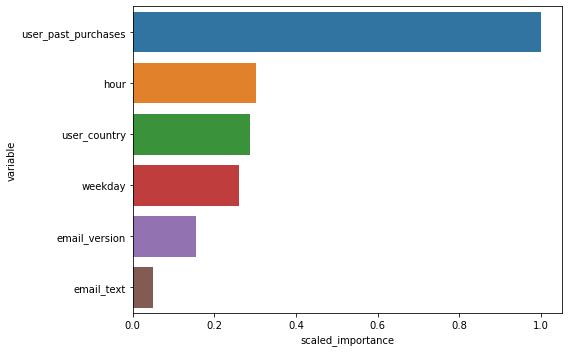

In [69]:
# Feature importance
importance = model.varimp(use_pandas=True)

fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x='scaled_importance', y='variable', data=importance)
plt.tight_layout()

In [70]:
# Make predictions
train_true = train.as_data_frame()['click'].values
test_true = test.as_data_frame()['click'].values
train_pred = model.predict(train).as_data_frame()['p1'].values
test_pred = model.predict(test).as_data_frame()['p1'].values

train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

# Classification report
print(classification_report(y_true=test_true, y_pred=(test_pred > 0.5).astype(int)))

drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


/Users/yli/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.98      1.00      0.99     24470
           1       0.00      0.00      0.00       530

    accuracy                           0.98     25000
   macro avg       0.49      0.50      0.49     25000
weighted avg       0.96      0.98      0.97     25000



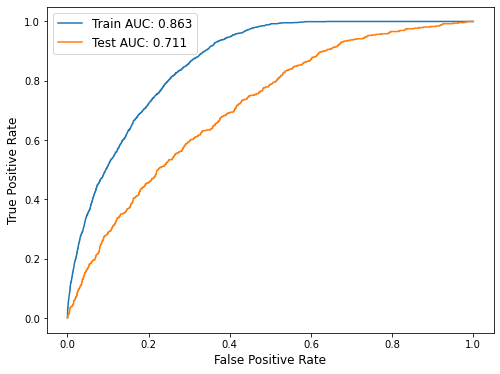

In [71]:
# ROC curves
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


/Users/yli/opt/anaconda3/lib/python3.8/site-packages/h2o/model/model_base.py:1394: MatplotlibDeprecationWarning: Since 3.2, the parameter *where* must have the same size as [0 1] in fill_betweenx(). This will become an error two minor releases later.
  axs.fill_between(x, lower, upper, where=lower < upper, alpha=0.1, interpolate=False)
/Users/yli/opt/anaconda3/lib/python3.8/site-packages/h2o/model/model_base.py:1394: MatplotlibDeprecationWarning: Since 3.2, the parameter *where* must have the same size as [1.0 2.2105263157894735 3.4210526315789473 4.631578947368421
 5.842105263157895 7.052631578947368 8.263157894736842 9.473684210526315
 10.68421052631579 11.894736842105264 13.105263157894736 14.31578947368421
 15.526315789473685 16.736842105263158 17.94736842105263
 19.157894736842106 20.36842105263158 21.57894736842105 22.789473684210527
 24.0] in fill_betweenx(). This will become an error two minor releases later.
  axs.fill_between(x, lower, upper, where=lower < upper, alpha=0.1, i

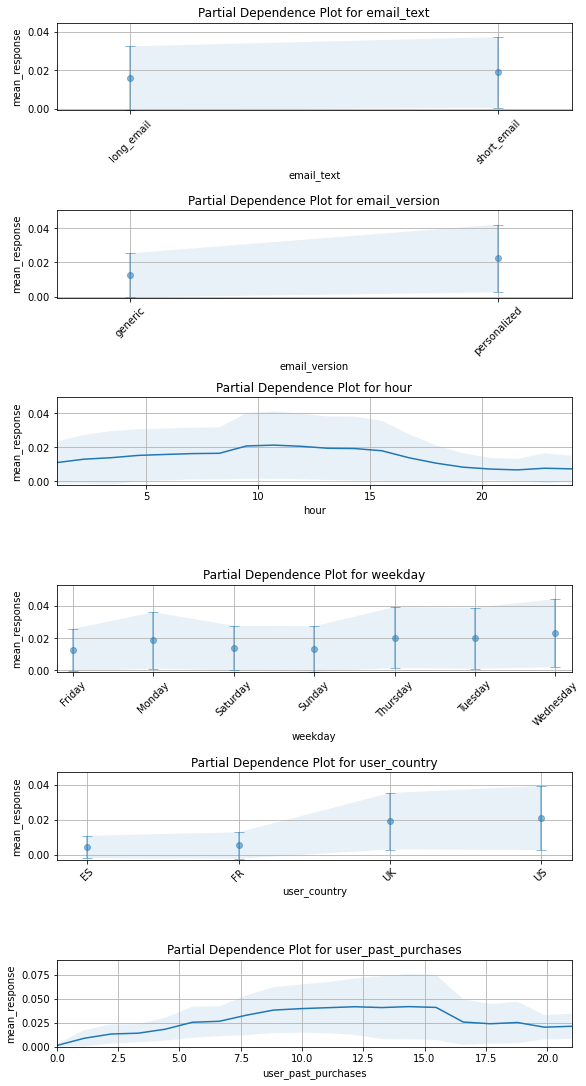

In [72]:
# partial_plot
## the blue block represents the confidence interval
_ = model.partial_plot(train, cols=feature, figsize=(8, 15))

In [94]:
# Shutdown h2o instance
h2o.cluster().shutdown()

H2O session _sid_a579 closed.


It seems that currently there are some overfitting, which could be solved with grid search.

# Question 3

Based on the model built previously, the company can send email to selected users that are predicted to have higher probability to click the link. 

To test it, we can conduct A/B test to see if the built model can actually help improve the click-through-rate.
* Randomly assign users to two groups, Control group and Experiment group.
* In Control group, still use the old email-campaign strategy, i.e., just send emails to all users in Control group.
* In Experiment group, use my model to predict whether the user will click the link or not. and only send emails to those users whose predictive result is positive.
* Preform a one-tail unpaired t-test to test whether Experiement group's population proportion is higher than Control group's population proportion.

# Question 4

See visualization and partial dependence plot for details, which should be very clear.